[View in Colaboratory](https://colab.research.google.com/github/joaoflf/ml-playground/blob/master/kaggle_titanic.ipynb)

## Titanic Kaggle Competition

My attempt of this competition using deep neural networks.

The best result turned out to be the current selected features, no dropout and batch training on the full training set

---
Start by importing and setting up Tensorboard

In [23]:
import os
if not os.path.exists('./colab_utils'):
  !git clone https://github.com/mixuala/colab_utils.git
    
import colab_utils.tboard
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime

now = datetime.utcnow().strftime('%Y%m%d%H%M%S')
ROOT = %pwd
root_log_dir = os.path.join(ROOT, 'tf_logs')
colab_utils.tboard.launch_tensorboard( bin_dir=ROOT, log_dir=root_log_dir )

ngrok installed
status: tensorboard=True, ngrok=True
tensorboard url= https://873baa70.ngrok.io


'https://873baa70.ngrok.io'

Download and extract train and test csv files and load them into Pandas data frame



In [24]:
!rm -rf data
if not os.path.exists('./data'):
  !mkdir data
  !wget -O ./data/train.csv https://www.dropbox.com/s/47sadlv7emve5i4/train.csv?raw=1
  !wget -O ./data/test.csv https://www.dropbox.com/s/p4l8elh79agtyvw/test.csv?raw=1



--2018-06-14 16:58:17--  https://www.dropbox.com/s/47sadlv7emve5i4/train.csv?raw=1
Resolving www.dropbox.com (www.dropbox.com)... 162.125.9.1, 2620:100:601f:1::a27d:901
Connecting to www.dropbox.com (www.dropbox.com)|162.125.9.1|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://uc923480c7de21a030163d692baa.dl.dropboxusercontent.com/cd/0/inline/AI368vhq5OYaoJs9rNRMIqPGeC-VEYgVr85JwOMep1WBOdUzUCnE-3fWXMqQiUsCugLWs--3qCmRWLwHiuBsuyVrKFkEKvs5QGmcaYgheypDXCMcXHVXYt-Z95cBWStf4aqVxqjH9BoZcqlRxpG1ac5UjXV1Ew6xiXd89FGx5gJWCMf6oKef0cH1Ty2wImykThw/file [following]
--2018-06-14 16:58:18--  https://uc923480c7de21a030163d692baa.dl.dropboxusercontent.com/cd/0/inline/AI368vhq5OYaoJs9rNRMIqPGeC-VEYgVr85JwOMep1WBOdUzUCnE-3fWXMqQiUsCugLWs--3qCmRWLwHiuBsuyVrKFkEKvs5QGmcaYgheypDXCMcXHVXYt-Z95cBWStf4aqVxqjH9BoZcqlRxpG1ac5UjXV1Ew6xiXd89FGx5gJWCMf6oKef0cH1Ty2wImykThw/file
Resolving uc923480c7de21a030163d692baa.dl.dropboxusercontent.com (uc923480c7de21a030163d692baa.dl.dropb

Load and split dataset

In [82]:
train_set = pd.read_csv('./data/train.csv')
test_set = pd.read_csv('./data/test.csv')
train_set.reindex(np.random.permutation(train_set.index))
train_cv_ratio = 0.7
train_size = int(train_set.shape[0] * train_cv_ratio)
cv_size = train_set.shape[0] - train_cv_ratio
cv_set = train_set[train_size:]
train_set = train_set[:train_size]

train_set.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


Build a feature pipeline to:


1.   Group age values in categories VS having discrete values
2.   Compute family size by adding siblings and children§
3.   One-hot encode categories

In [0]:
age_points = [-1,0,5,18,60,100]
age_labels = ["Missing","Infant","Child","Adult","Senior"]
features_to_encode = ['Age_categories', 'Sex', 'Pclass', 'Embarked']
important_features = ['Single_Male', 'Age_categories_Missing', 'Age_categories_Infant', 'Age_categories_Child', 'Age_categories_Adult',	'Age_categories_Senior', 'Sex_female', 'Sex_male', 'Pclass_1', 'Pclass_2', 'Pclass_3', 'FamilySize']

def group_feature_values(df,feature,cut_points,label_names):
  df[feature] = df[feature].fillna(-0.5)
  df[feature+'_categories'] = pd.cut(df[feature],cut_points,labels=label_names)
  return df

def compute_family_size(df):
  df['SibSp'].fillna(-0.5)
  df['Parch'].fillna(-0.5)
  df['FamilySize'] = df['SibSp'] + df['Parch']
  return df

def compute_women_parch(df):
  df['Women_Children'] = np.where(np.logical_and(df['Sex'] == 'female', df['Parch'] > 0), 1, 0 )
  return df

def compute_women_sibsp(df):
  df['Women_Spouse'] = np.where(np.logical_and(df['Sex'] == 'female', df['SibSp'] > 0), 1, 0 )
  return df

def compute_single_males(df):
  df['Single_Male'] = np.where(np.logical_and(np.logical_and(df['Sex'] == 'male', df['SibSp'] == 0), df['Parch'] == 0), 1, 0 )
  return df

def one_hot_encode(df, features):
  for feature in features:
    dummies = pd.get_dummies(df[feature], prefix=feature, drop_first=False)
    df = pd.concat([df, dummies], axis=1)
  return df

def feature_pipeline(df):
  df = group_feature_values(df,'Age' ,age_points,age_labels)
  df = compute_family_size(df)
  df = compute_women_parch(df)
  df = compute_women_sibsp(df)
  df = compute_single_males(df)
  df = one_hot_encode(df, features_to_encode)
  return df

def get_training_data(df):
  return df[important_features].values

def get_labels(df):
  return np.expand_dims(df['Survived'], axis= 1)


Utils for training

In [0]:
def get_training_data(df):
  return df[important_features].values

def get_labels(df):
  return np.expand_dims(df['Survived'], axis= 1)

Analyse features' relationship with survival

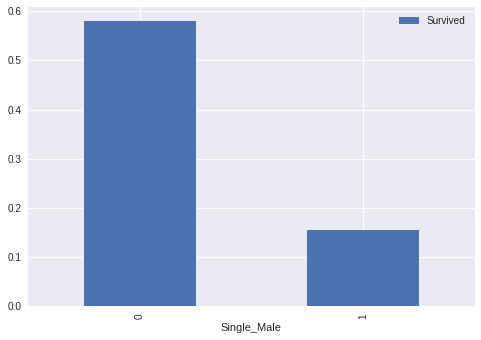

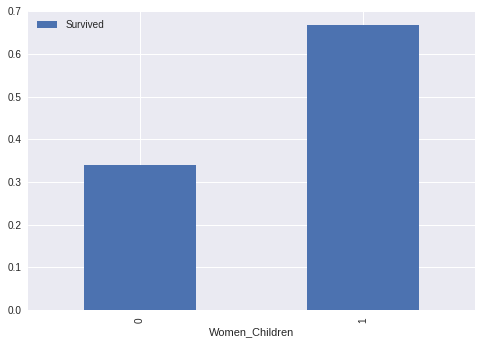

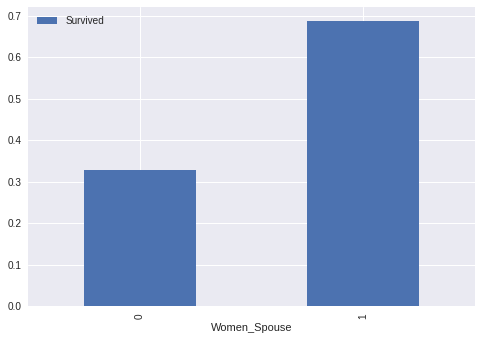

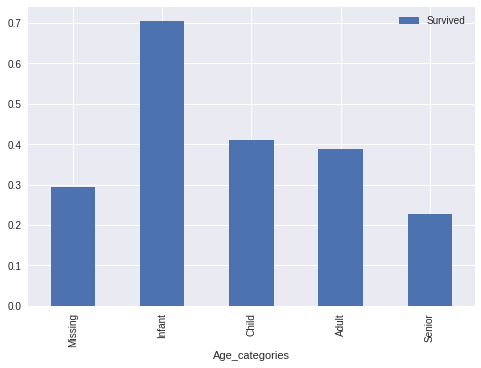

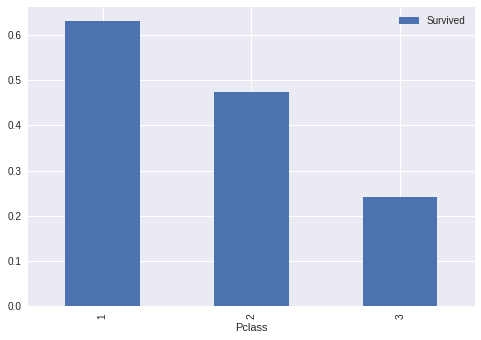

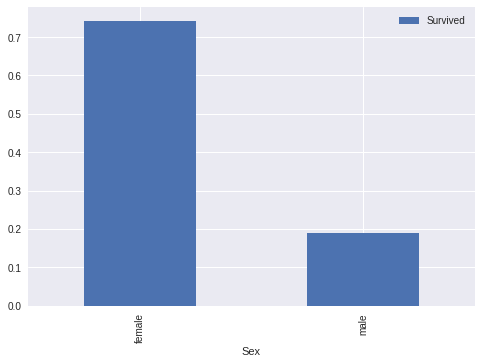

In [90]:
def survived_ratio(df, feature):
  pivot = train.pivot_table(index=feature ,values='Survived')
  pivot.plot.bar()
  plt.show()

  
train = feature_pipeline(train_set)

survived_ratio(train, 'Single_Male')
survived_ratio(train, 'Women_Children')
survived_ratio(train, 'Women_Spouse')
survived_ratio(train, 'Age_categories')
survived_ratio(train, 'Pclass')
survived_ratio(train, 'Sex')

Build neural network model

In [0]:
tf.reset_default_graph()

learning_rate = 0.0001
momentum = 0.95
no_features = len(important_features)

X = tf.placeholder(tf.float32, shape= [None, no_features])
y = tf.placeholder(tf.int32, shape= [None, 1])

he_init = tf.contrib.layers.variance_scaling_initializer()
regularizer = tf.contrib.layers.l2_regularizer(scale=0.1)
training = tf.placeholder_with_default(False, shape=(), name='training')
dropout_rate = 0.3

with tf.name_scope('network'):
  dense_1 = tf.layers.dropout(tf.contrib.layers.batch_norm(tf.layers.dense(X, 100, activation=tf.nn.relu, kernel_initializer=he_init, kernel_regularizer=regularizer, name='dense_1')),dropout_rate, training=training)
  dense_2 = tf.layers.dropout(tf.contrib.layers.batch_norm(tf.layers.dense(dense_1, 100, activation=tf.nn.relu, kernel_initializer=he_init,  kernel_regularizer=regularizer, name='dense_2')),dropout_rate, training=training)
  dense_3 = tf.layers.dropout(tf.contrib.layers.batch_norm(tf.layers.dense(dense_2, 50, activation=tf.nn.relu, kernel_initializer=he_init,  kernel_regularizer=regularizer, name='dense_3')),dropout_rate, training=training)
  dense_4 = tf.layers.dropout(tf.contrib.layers.batch_norm(tf.layers.dense(dense_3, 10, activation=tf.nn.relu, kernel_initializer=he_init,  kernel_regularizer=regularizer, name='dense_4')),dropout_rate, training=training)

  logits = tf.layers.dense(dense_2, 1, name='logits', kernel_initializer=he_init)

  y_prob = tf.nn.sigmoid(logits)
  y_pred = tf.cast(tf.greater_equal(logits, 0), tf.int32)

with tf.name_scope('loss'):
  y_as_float = tf.cast(y, tf.float32)
  xentropy = tf.nn.sigmoid_cross_entropy_with_logits(labels=y_as_float, logits=logits)
  loss = tf.reduce_mean(xentropy, name='loss')

with tf.name_scope('train'):
  optimizer = tf.train.AdamOptimizer(learning_rate)
  training_op = optimizer.minimize(loss)

with tf.name_scope('eval'):
  y_pred_correct = tf.equal(y_pred, y)
  accuracy = tf.reduce_mean(tf.cast(y_pred_correct, tf.float32), name='accuracy')


loss_summary = tf.summary.scalar('Loss', loss)
init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [100]:
import time
now = datetime.utcnow().strftime("%Y%m%d%H%M%S")
logdir = "{}/run-{}/".format(root_log_dir, now)
file_writer = tf.summary.FileWriter(logdir, tf.get_default_graph())

train = feature_pipeline(train_set)
cv = feature_pipeline(cv_set)
test = feature_pipeline(test_set)

X_train, y_train = get_training_data(train), get_labels(train)
X_cv, y_cv = get_training_data(cv), get_labels(cv)
X_test = get_training_data(test)

n_epochs = 10000
batch_size = 128
batch_step = 0

start_time = time.time()

with tf.Session() as sess:
  init.run()
  for epoch in range(n_epochs):
    idx = np.random.permutation(len(X_train))
    for indices in np.array_split(idx, len(idx) // batch_size):
      X_batch, y_batch = X_train[indices], y_train[indices]
      sess.run(training_op, feed_dict={X: X_batch, y: y_batch, training:True})
      summary_str, acc_train, loss_str = sess.run([loss_summary, accuracy, loss], feed_dict={X: X_batch, y: y_batch, training:True})
      file_writer.add_summary(summary_str,batch_step)
    
    batch_step+=1
    if epoch % 1000 == 0:
      print(epoch, "Train accuracy:", acc_train, 'Loss:', loss_str)

  acc_test = accuracy.eval(feed_dict={X: X_cv, y: y_cv})
  print("CV accuracy:", acc_test)
  
  prediction = sess.run([y_pred], feed_dict={X: X_test, training:False})
 
  file_writer.close()
  sess.close()
  print("--- %s seconds ---" % (time.time() - start_time))

0 Train accuracy: 0.6418919 Loss: 0.635719
1000 Train accuracy: 0.777027 Loss: 0.49695885
2000 Train accuracy: 0.8716216 Loss: 0.32925123
3000 Train accuracy: 0.8243243 Loss: 0.39185858
4000 Train accuracy: 0.8175676 Loss: 0.34675282
5000 Train accuracy: 0.8108108 Loss: 0.36324203
6000 Train accuracy: 0.8716216 Loss: 0.3182923
7000 Train accuracy: 0.8310811 Loss: 0.37944368
8000 Train accuracy: 0.8040541 Loss: 0.41574204
9000 Train accuracy: 0.8648649 Loss: 0.3493451
--- 310.92419385910034 seconds ---


Train Model

In [0]:
from google.colab import files

predictiona = np.transpose(np.array(prediction))
predictionpd = pd.DataFrame(predictiona[0], columns=['Survived'])
filename = 'full_set_0_drop'
submission = pd.concat([test_set['PassengerId'], predictionpd], axis=1).to_csv(filename, index=False)
files.download(filename)